In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [6]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

DATASET_PATH = r"D:\ML PROJECTS\Age Detection on UTKFace Dataset\UTKFace"
IMG_SIZE = 100  # Smaller size to save memory
LIMIT = 5000    # Load only first 5000 images

images = []
ages = []

for idx, file_name in enumerate(os.listdir(DATASET_PATH)):
    if idx >= LIMIT:
        break
    try:
        file_path = os.path.join(DATASET_PATH, file_name)
        age = int(file_name.split("_")[0])
        img = cv2.imread(file_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0  # Normalize
        images.append(img)
        ages.append(age)
        if idx % 500 == 0:
            print(f"Loaded {idx} images...")
    except Exception as e:
        print(f"Skipping {file_name}: {e}")

X = np.array(images, dtype=np.float32)
y = np.array(ages, dtype=np.int32)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


Loaded 0 images...
Loaded 500 images...
Loaded 1000 images...
Loaded 1500 images...
Loaded 2000 images...
Loaded 2500 images...
Loaded 3000 images...
Loaded 3500 images...
Loaded 4000 images...
Loaded 4500 images...
Training samples: 4000
Testing samples: 1000


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1)  # Regression output (age)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32
)



c:\Users\yuvan\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 144.2979 - mae: 9.4445 - val_loss: 87.8765 - val_mae: 5.3333
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 80.7725 - mae: 5.5467 - val_loss: 78.1077 - val_mae: 4.5840
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 72.7312 - mae: 5.0934 - val_loss: 77.0480 - val_mae: 4.6626
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 83.7900 - mae: 5.1482 - val_loss: 73.1296 - val_mae: 4.2269
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 71.2106 - mae: 4.8179 - val_loss: 73.5651 - val_mae: 4.5731
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 85.0353 - mae: 5.0405 - val_loss: 74.6494 - val_mae: 4.2982
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 57.3104 - mae: 4.4325 - val_loss: 68.4869 - val_mae: 4.3335
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 76.7678 - mae: 5.1100 - val_loss: 65.3989 - val_mae: 4.0932
Epoch 9/15
125/125 ━━━━━━━━━━━━

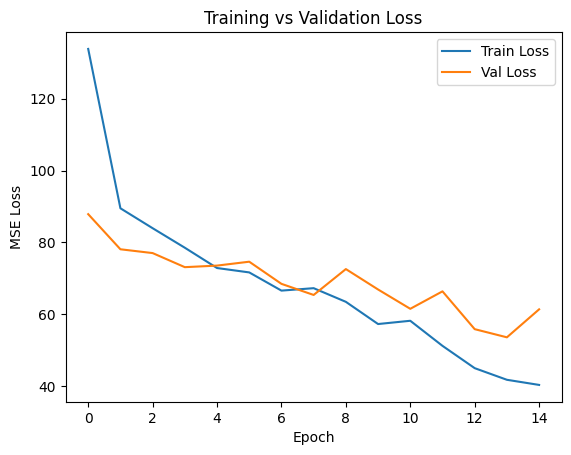

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 63.2646 - mae: 4.6981

Test Mean Absolute Error (MAE): 4.64 years


In [8]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"\nTest Mean Absolute Error (MAE): {test_mae:.2f} years")


In [9]:
# Save full model
model.save("age_detector_model.h5")

# Save weights only
model.save_weights("age_detector_weights.h5")

print("Model and weights saved successfully.")


ValueError: The filename must end in `.weights.h5`. Received: filepath=age_detector_weights.h5

In [12]:
def predict_age(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    return prediction[0][0]

# Example usage
predicted_age = predict_age(r"D:\ML PROJECTS\Age Detection on UTKFace Dataset\UTKFace\1_0_0_20161219140642920.jpg.chip.jpg", model)
print(f"Predicted Age: {predicted_age:.2f} years")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Age: 3.17 years
